In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline                                           
from sklearn.preprocessing import StandardScaler                                     
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from multiprocessing import Pool
from tqdm import tqdm
from arangopipe.arangopipe_analytics.rf_dataset_shift_detector import RF_DatasetShiftDetector
%run -i '../../../../../../utils.py'

# Get data

In [2]:
# read meta data
df_meta = pd.read_csv('../../../../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin'] # only for inulin group
df_meta = df_meta[df_meta.Day != 0] # remove day 0

# read SCFA data
df_scfa = pd.read_csv('../../../../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance
df_bac = pd.read_csv('../../../../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# find common samples
common_samples = list(set(df_meta.index).intersection(df_scfa.index).intersection(df_bac.index))
df_meta = df_meta.loc[common_samples]
df_scfa = df_scfa.loc[common_samples]
df_bac = df_bac.loc[common_samples]

# Run dataset shift detector

## intrapolation

In [5]:
for group_to_exclude in ['A','B','C','D']:

    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.RandomizedGroup!=group_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.RandomizedGroup==group_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get train and test data
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    rfd = RF_DatasetShiftDetector()
    score = rfd.detect_dataset_shift(xdata_train, xdata_test)
    print ("Detaset shift score (%s): %2.2f" % (group_to_exclude, score))

Detaset shift score (A): 0.80
Detaset shift score (B): 0.80
Detaset shift score (C): 0.80
Detaset shift score (D): 0.84


## extrapolation

In [6]:
for vendor_to_exclude in ['Beijing','Guangdong','Hunan','Shanghai']:
        
    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.Vendor!=vendor_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.Vendor==vendor_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get train and test data
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    rfd = RF_DatasetShiftDetector()
    score = rfd.detect_dataset_shift(xdata_train, xdata_test)
    print ("Detaset shift score (%s): %2.2f" % (vendor_to_exclude, score))

Detaset shift score (Beijing): 1.00
Detaset shift score (Guangdong): 1.00
Detaset shift score (Hunan): 0.98
Detaset shift score (Shanghai): 1.00


## calculate R2

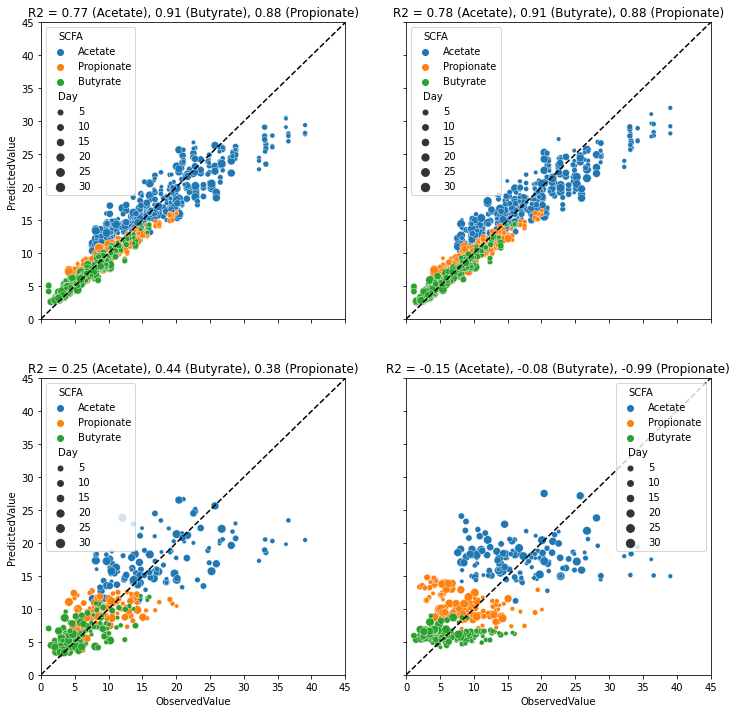

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)
 
for k,ptype in enumerate(['train','test']):
    # intrapolation
    df_intra_tmp = df_pred_intra[df_pred_intra['PredictionType']==ptype]
    _ = sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_intra_tmp, ax=ax[k,0])
    # extrapolation
    df_extra_tmp = df_pred_extra[df_pred_extra['PredictionType']==ptype]
    _ = sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_extra_tmp, ax=ax[k,1])
    
    # calculate R2
    r2_intra = []
    r2_extra = []
    for scfa in ['Acetate','Butyrate','Propionate']:
        # intrapolation
        df_intra_tmp2 = df_intra_tmp[df_intra_tmp.SCFA==scfa]
        r2_intra.append(r2_score(df_intra_tmp2.ObservedValue, df_intra_tmp2.PredictedValue))
        # extrapolation
        df_extra_tmp2 = df_extra_tmp[df_extra_tmp.SCFA==scfa]
        r2_extra.append(r2_score(df_extra_tmp2.ObservedValue, df_extra_tmp2.PredictedValue))
   
    # add title
    _ = ax[k,0].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2_intra[0], 'Acetate', r2_intra[1], 'Butyrate', r2_intra[2], 'Propionate'))
    _ = ax[k,1].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2_extra[0], 'Acetate', r2_extra[1], 'Butyrate', r2_extra[2], 'Propionate'))
    
    # set xlim and ylim
    _ = ax[0,k].set_xlim([0,45])
    _ = ax[1,k].set_xlim([0,45])
    _ = ax[0,k].set_ylim([0,45])
    _ = ax[1,k].set_ylim([0,45])
    _ = ax[0,k].plot([0,45],[0,45],'k--')
    _ = ax[1,k].plot([0,45],[0,45],'k--')